In [1]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.19.0
2.0.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# 데이터 load 및 압축 해제

import os
import zipfile

# 데이터 루트 경로 - 미리 다운받아둔 데이터로 실험 진행
data_path = '/content/drive/MyDrive'
rps_path = os.path.join(data_path, 'rsp')

# 압축 파일 목록
zip_files = {
    'rock.zip': 'rock',
    'scissor.zip': 'scissor',
    'paper.zip': 'paper'
}

for zip_name, folder_name in zip_files.items():
    zip_path = os.path.join(rps_path, zip_name)           # zip 파일 전체 경로
    extract_dir = os.path.join(rps_path, folder_name)     # 압축 해제될 폴더

    # 폴더 없으면 생성
    os.makedirs(extract_dir, exist_ok=True)

    print(f"🔍 압축 해제 중: {zip_name} → {extract_dir}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

print("✅ 모든 압축 해제 완료!")

🔍 압축 해제 중: rock.zip → /content/drive/MyDrive/rsp/rock
🔍 압축 해제 중: scissor.zip → /content/drive/MyDrive/rsp/scissor
🔍 압축 해제 중: paper.zip → /content/drive/MyDrive/rsp/paper
✅ 모든 압축 해제 완료!


In [4]:
# 이미지 resize 방식 사용

from PIL import Image
import glob

def resize_images(img_path):
  images=glob.glob(img_path + "/*.jpg")

  print(len(images), " images to be resized.")

  # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
  target_size=(28,28)
  for img in images:
    old_img=Image.open(img)
    # new_img=old_img.resize(target_size,Image.ANTIALIAS)
    new_img = old_img.resize(target_size, Image.Resampling.LANCZOS)
    new_img.save(img, "JPEG")

  print(len(images), " images resized.")

# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
rock_img_path = os.path.join(rps_path, 'rock')
resize_images(rock_img_path)

print("바위 이미지 resize 완료!")

100  images to be resized.
100  images resized.
바위 이미지 resize 완료!


In [5]:
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
scissor_img_path = os.path.join(rps_path, 'scissor')
paper_img_path = os.path.join(rps_path, 'paper')

resize_images(scissor_img_path)
resize_images(paper_img_path)

100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


In [6]:
import numpy as np

def load_data(img_path):
    # 가위 : 0, 바위 : 1, 보 : 2
    imgs = []
    labels = []

    # 1. scissor
    for file in glob.iglob(os.path.join(img_path, 'scissor', '*.jpg')):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs.append(img)
        labels.append(0)   # 가위 : 0

    # 2. rock
    for file in glob.iglob(os.path.join(img_path, 'rock', '*.jpg')):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs.append(img)
        labels.append(1)   # 바위 : 1

    # 3. paper
    for file in glob.iglob(os.path.join(img_path, 'paper', '*.jpg')):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs.append(img)
        labels.append(2)   # 보 : 2

    # 리스트 → 넘파이 배열로 변환
    imgs = np.stack(imgs, axis=0)              # (N, H, W, C)
    labels = np.array(labels, dtype=np.int32)  # (N,)

    print("학습데이터(x_train)의 이미지 개수는", len(labels), "입니다.")
    return imgs, labels

# 사용 예시
x_train, y_train = load_data(rps_path)
x_train_norm = x_train / 255.0

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

학습데이터(x_train)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


라벨:  1


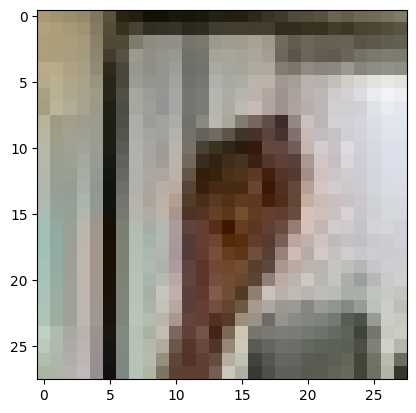

In [7]:

# 이미지 확인 - 화질이 생각보다 상당히 안좋은것을 확인할수있다

import matplotlib.pyplot as plt

plt.imshow(x_train[123])
print('라벨: ', y_train[123])


In [8]:

# 모델 만들기

import tensorflow as tf
from tensorflow import keras
import numpy as np

# 아래의 하이퍼파라미터는 예시입니다. 높은 인식률을 얻기 위해 하이퍼파라미터를 수정해 보세요.
n_channel_1=16
n_channel_2=32
n_dense=32
n_train_epoch=10

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,819 (120.39 KB)

 Trainable params: 30,819 (120.39 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

# 모델 훈련
model.fit(x_train, y_train, epochs=n_train_epoch)

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7446 - loss: 1.9665
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8534 - loss: 0.3886
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9417 - loss: 0.1541
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9827 - loss: 0.0511
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0336
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9983 - loss: 0.0150
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0101
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0091
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0073
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0056


In [13]:
# 테스트용 데이터 불러오기

# 압축 파일 목록
zip_files = {
    'rock (1).zip': 'rock_test',
    'scissor (1).zip': 'scissor_test',
    'paper (1).zip': 'paper_test'
}

for zip_name, folder_name in zip_files.items():
    zip_path = os.path.join(rps_path, zip_name)           # zip 파일 전체 경로
    extract_dir = os.path.join(rps_path, folder_name)     # 압축 해제될 폴더

    # 폴더 없으면 생성
    os.makedirs(extract_dir, exist_ok=True)

    print(f"🔍 압축 해제 중: {zip_name} → {extract_dir}")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

print("✅ 모든 압축 해제 완료!")

🔍 압축 해제 중: rock (1).zip → /content/drive/MyDrive/rsp/rock_test
🔍 압축 해제 중: scissor (1).zip → /content/drive/MyDrive/rsp/scissor_test
🔍 압축 해제 중: paper (1).zip → /content/drive/MyDrive/rsp/paper_test
✅ 모든 압축 해제 완료!


In [14]:
# 이미지 전처리
rock_test_img_path = os.path.join(rps_path, 'rock_test')
resize_images(rock_test_img_path)
scissor_test_img_path = os.path.join(rps_path, 'scissor_test')
resize_images(scissor_test_img_path)
paper_test_img_path = os.path.join(rps_path, 'paper_test')
resize_images(paper_test_img_path)


100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.
100  images to be resized.
100  images resized.


In [15]:
# 이미지 - 라벨 (하나하나를 맞춰주는 코드를 작성한다)

import numpy as np

def load_test_data(img_path):
    # 가위 : 0, 바위 : 1, 보 : 2
    imgs = []
    labels = []

    # 1. scissor
    for file in glob.iglob(os.path.join(img_path, 'scissor_test', '*.jpg')):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs.append(img)
        labels.append(0)   # 가위 : 0

    # 2. rock
    for file in glob.iglob(os.path.join(img_path, 'rock_test', '*.jpg')):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs.append(img)
        labels.append(1)   # 바위 : 1

    # 3. paper
    for file in glob.iglob(os.path.join(img_path, 'paper_test', '*.jpg')):
        img = np.array(Image.open(file), dtype=np.int32)
        imgs.append(img)
        labels.append(2)   # 보 : 2

    # 리스트 → 넘파이 배열로 변환
    imgs = np.stack(imgs, axis=0)              # (N, H, W, C)
    labels = np.array(labels, dtype=np.int32)  # (N,)

    print("학습데이터(x_test)의 이미지 개수는", len(labels), "입니다.")
    return imgs, labels

# 사용 예시
x_test, y_test = load_test_data(rps_path)
x_test_norm = x_test / 255.0

print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

학습데이터(x_test)의 이미지 개수는 300 입니다.
x_test shape: (300, 28, 28, 3)
y_test shape: (300,)


In [16]:

# 테스트

test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - 41ms/step - accuracy: 0.3967 - loss: 1.4137
test_loss: 1.4136911630630493 
test_accuracy: 0.39666667580604553


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


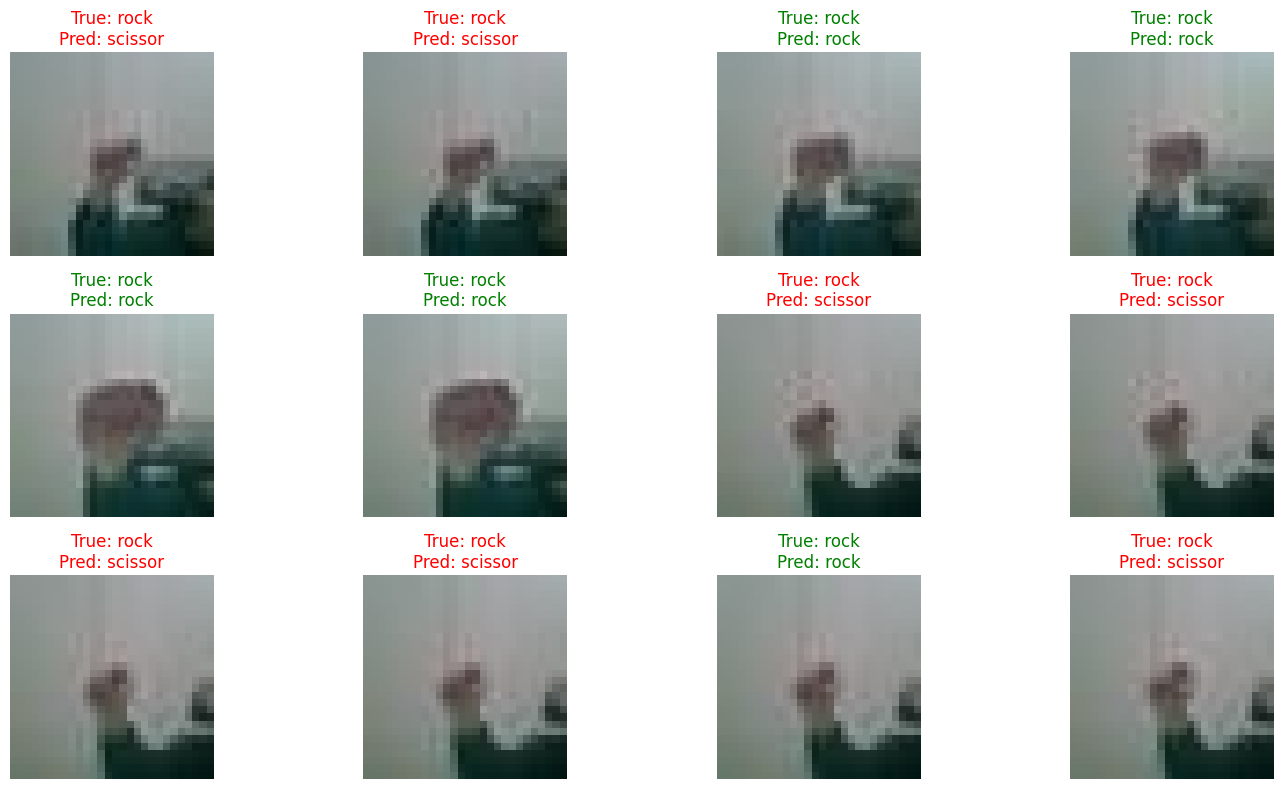

In [17]:
# 시각화

import matplotlib.pyplot as plt
import numpy as np

# 클래스 이름 매핑
class_names = ['scissor', 'rock', 'paper']   # 0, 1, 2

# 모델 예측
pred = model.predict(x_test)          # (N, 3)
pred_label = np.argmax(pred, axis=1)  # 예측 라벨

# 원하는 만큼 출력
start_idx = 100
num_images = 12
plt.figure(figsize=(15, 8))

for i in range(num_images):
    plt.subplot(3, 4, i+1)
    plt.imshow(x_test[start_idx+i])
    plt.axis('off')

    true_name = class_names[y_test[start_idx+i]]
    pred_name = class_names[pred_label[start_idx+i]]

    # 정답 / 예측 출력
    color = 'green' if y_test[start_idx+i] == pred_label[start_idx+i] else 'red'
    plt.title(f"True: {true_name}\nPred: {pred_name}", color=color)

plt.tight_layout()
plt.show()